In [1]:
import os
from functools import partial

import numpy
import scipy
from matplotlib import pyplot

import lebesgue
import pyhf_stuff

from pyhf_stuff import fit_linspace, fit_signal, fit_mcmc_mix
from pyhf_stuff import fit_cabinetry, fit_normal

In [2]:
BASE = "/home/tombs/Cambridge/interval-evidence/searches/ins1852821/SR0bvetotight/fit/"
NDATA = 1

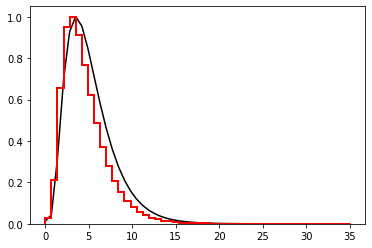

In [3]:
def test():
    # max scan
    linspace = fit_linspace.FitLinspace.load(BASE)
    x = numpy.linspace(linspace.start, linspace.stop, len(linspace.levels))
    y = numpy.array(linspace.levels)
    pyplot.plot(x, numpy.exp(y.min() - y), "k")
    
    # mcmc sample
    mcmc = fit_mcmc_mix.FitMcmcMix.load(BASE)
    x = numpy.linspace(*mcmc.range_, len(mcmc.yields) + 1)
    y = numpy.array(mcmc.yields)
    pyplot.hist(
        x[:-1], 
        weights=y / y.max(), 
        range=mcmc.range_, 
        bins=len(x) - 1,
        histtype="step",
        color="r",
        lw=2,
    )
    
    pyplot.show()
    
test()

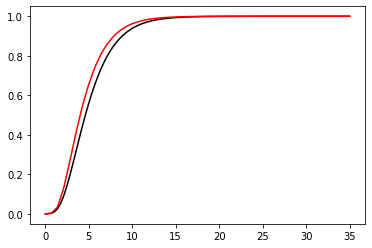

In [4]:
def model_from_linspace(n, fit):
    return partial(
        lebesgue.canned.gamma1_regular_linear,
        n, 
        fit.start,
        fit.stop,
        numpy.negative(fit.levels),
    )


def model_from_mcmc(n, fit):
    return partial(
        lebesgue.canned.gamma1_regular_uniform,
        n, 
        *fit.range_,
        numpy.log(fit.yields),
    )


def test_models():
    linspace = fit_linspace.FitLinspace.load(BASE)
    mcmc = fit_mcmc_mix.FitMcmcMix.load(BASE)
    
    model_linspace = model_from_linspace(NDATA, linspace)(shift=0)
    model_mcmc = model_from_mcmc(NDATA, mcmc)(shift=0)
    
    x = numpy.linspace(0, 35, 100)
    
    y_linspace = [
        model_linspace.prior.between(0, x_i)
        for x_i in x
    ]
    y_mcmc = [
        model_mcmc.prior.between(0, x_i)
        for x_i in x
    ]
    
    pyplot.plot(x, y_linspace, "k")
    pyplot.plot(x, y_mcmc, "r")
    pyplot.show()
    
test_models()    

In [5]:
def interval_divide(a, b):
    """Return bounds on a / b.
    
    Arguments:
        a: shape (..., 2) with lo, hi in the last axis
            non-negative
        b: shape (..., 2) similarly
            positive
    """
    return a / b[..., ::-1]

1


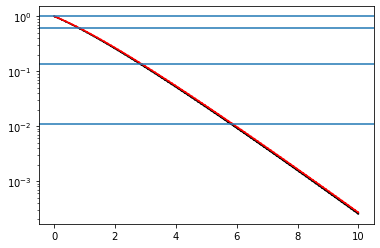

3.5


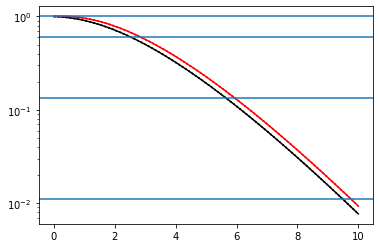

In [6]:
def test_limits(n):
    print(n)
    linspace = fit_linspace.FitLinspace.load(BASE)
    mcmc = fit_mcmc_mix.FitMcmcMix.load(BASE)
    
    model_linspace = model_from_linspace(n, linspace)
    model_mcmc = model_from_mcmc(n, mcmc)
    
    signal = numpy.linspace(0, 10, 101)
    
    rtol=1e-3
    z_linspace = []
    z_mcmc = []
    for x_i in signal:
        z_linspace.append(model_linspace(shift=x_i).integrate(rtol=rtol))
        z_mcmc.append(model_mcmc(shift=x_i).integrate(rtol=rtol))
    z_linspace = numpy.array(z_linspace)
    z_mcmc = numpy.array(z_mcmc)
    
    r_linspace = interval_divide(z_linspace, z_linspace[0])
    r_mcmc = interval_divide(z_mcmc, z_mcmc[0])
    
    pyplot.plot(signal, r_linspace.mean(axis=1), "k")
    pyplot.plot(signal, r_linspace[:, 0], "k:")
    pyplot.plot(signal, r_linspace[:, 1], "k:")
    pyplot.plot(signal, r_mcmc.mean(axis=1), "r")
    pyplot.plot(signal, r_mcmc[:, 0], "r:")
    pyplot.plot(signal, r_mcmc[:, 1], "r:")
    pyplot.axhline(numpy.exp(-0.0))
    pyplot.axhline(numpy.exp(-0.5))
    pyplot.axhline(numpy.exp(-2.))
    pyplot.axhline(numpy.exp(-4.5))
#     pyplot.ylim(0)
    pyplot.yscale("log")
    pyplot.show()
        
test_limits(NDATA)
test_limits(3.5)

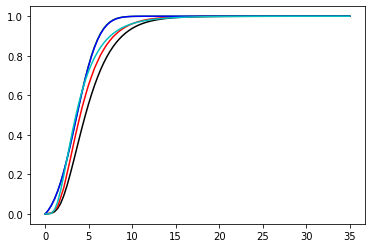

In [7]:
def model_from_cabinetry(n, fit):
    return partial(
        lebesgue.canned.gamma1_trunc_normal,
        n, 
        fit.yield_pre,
        fit.error_pre,
    )


def model_from_normal(n, fit):
    return partial(
        lebesgue.canned.gamma1_trunc_normal,
        n, 
        fit.yield_linear,
        fit.error_linear,
    )

def model_from_normal_log(n, fit):
    return partial(
        lebesgue.canned.gamma1_log_normal,
        n, 
        numpy.log(fit.yield_linear),
        fit.error_log,
    )


def test_models2():
    linspace = fit_linspace.FitLinspace.load(BASE)
    mcmc = fit_mcmc_mix.FitMcmcMix.load(BASE)
    cabinetry = fit_cabinetry.FitCabinetry.load(BASE)
    normal = fit_normal.FitNormal.load(BASE)
    
    model_linspace = model_from_linspace(NDATA, linspace)(shift=0)
    model_mcmc = model_from_mcmc(NDATA, mcmc)(shift=0)
    model_cabinetry = model_from_cabinetry(NDATA, cabinetry)(shift=0)
    model_normal = model_from_normal(NDATA, normal)(shift=0)
    model_normal_log = model_from_normal_log(NDATA, normal)(shift=0)
    
    x = numpy.linspace(0, 35, 100)
    
    y_linspace = [
        model_linspace.prior.between(0, x_i)
        for x_i in x
    ]
    y_mcmc = [
        model_mcmc.prior.between(0, x_i)
        for x_i in x
    ]
    y_cabinetry = [
        model_cabinetry.prior.between(0, x_i)
        for x_i in x
    ]
    y_normal = [
        model_normal.prior.between(0, x_i)
        for x_i in x
    ]
    y_normal_log = [
        model_normal_log.prior.between(0, x_i)
        for x_i in x
    ]
    
    pyplot.plot(x, y_linspace, "k")
    pyplot.plot(x, y_mcmc, "r")
    pyplot.plot(x, y_cabinetry, "g")
    pyplot.plot(x, y_normal, "b")
    pyplot.plot(x, y_normal_log, "c")
    pyplot.show()
    
test_models2()    

In [8]:
def quantile(prior, q, *, lo=0.0, x0=1.0, xtol=1e-4):
    if not 0. <= q <= 1.:
        raise ValueError(q)
    
    def func(x):
        return prior.between(lo, x) - q
    
    # initial expansion to find an upper bound
    hi = x0
    while not func(hi) > 0:
        hi *= 2
    
    return scipy.optimize.bisect(func, lo, hi, xtol=xtol)

def test_quantile():
    prior = lebesgue.canned.gamma1_trunc_normal(0, 1, 1).prior
    
    for q_i in scipy.special.ndtr([-1, 0, 1]):
        print(quantile(prior, q_i))
        
    
test_quantile()

0.45281982421875
1.20013427734375
2.11004638671875


In [9]:
def crosses(x: list[float], y: list[float], value: float):
    """Return lerps for where the curve x, y crosses value."""
    if not len(x) == len(y):
        raise ValueError((len(x), len(y)))
        
    results = []
    parts = zip(x[:-1], x[1:], y[:-1], y[1:])
    for x1, x2, y1, y2 in parts:
        if not min(y1, y2) <= value <= max(y1, y2):
            continue
        # no width special case
        if x1 == x2:
            return x1
        # no height special case: result is undefined
        if y1 == y2:
            return numpy.nan
        
        # linear interpolation
        x = x1 + (value - y1) * (x2 - x1) / (y2 - y1)
        results.append(x)
        
    return results

def test_crosses():
    x = [0, 1, 2, 3, 4, 5]
    y = [0, 1, 0, 1, -1, 3]
    print(crosses(x, y, 0.2))
    
test_crosses()

[0.2, 1.8, 2.2, 3.4, 4.3]


1
cabinetry  median: 3.63018798828125
normal     median: 3.63751220703125
normal_log median: 3.52349853515625
cabinetry  crosses -2: [3.1788291607185206]
normal     crosses -2: [3.1837092633444706]
normal_log crosses -2: [2.9038972983997]


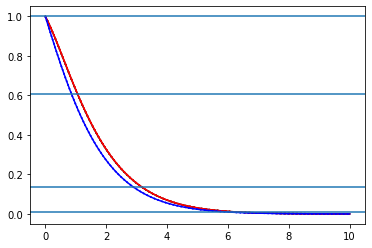

3.63
cabinetry  median: 3.63018798828125
normal     median: 3.63751220703125
normal_log median: 3.52349853515625
cabinetry  crosses -2: [6.6006535521160075]
normal     crosses -2: [6.607504354521802]
normal_log crosses -2: [6.439395822065197]


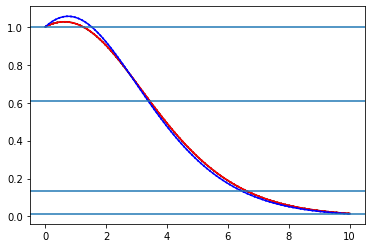

3.52
cabinetry  median: 3.63018798828125
normal     median: 3.63751220703125
normal_log median: 3.52349853515625
cabinetry  crosses -2: [6.436693450194106]
normal     crosses -2: [6.443656756636458]
normal_log crosses -2: [6.2636216826436195]


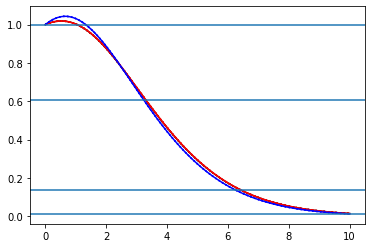

In [10]:
def test_limits2(n):
    print(n)
    cabinetry = fit_cabinetry.FitCabinetry.load(BASE)
    normal = fit_normal.FitNormal.load(BASE)
    
    model_cabinetry = model_from_cabinetry(n, cabinetry)
    model_normal = model_from_normal(n, normal)
    model_normal_log = model_from_normal_log(n, normal)
    
    signal = numpy.linspace(0, 10, 101)
    
    rtol=1e-3
    z_cabinetry = []
    z_normal = []
    z_normal_log = []
    for x_i in signal:
        z_cabinetry.append(model_cabinetry(shift=x_i).integrate(rtol=rtol))
        z_normal.append(model_normal(shift=x_i).integrate(rtol=rtol))
        z_normal_log.append(model_normal_log(shift=x_i).integrate(rtol=rtol))
        
    z_cabinetry = numpy.array(z_cabinetry)
    z_normal = numpy.array(z_normal)
    z_normal_log = numpy.array(z_normal_log)
    
    r_cabinetry = interval_divide(z_cabinetry, z_cabinetry[0])
    r_normal = interval_divide(z_normal, z_normal[0])
    r_normal_log = interval_divide(z_normal_log, z_normal_log[0])
    
    print("cabinetry  median:", quantile(model_cabinetry().prior, 0.5))
    print("normal     median:", quantile(model_normal().prior, 0.5))
    print("normal_log median:", quantile(model_normal_log().prior, 0.5))
    
    print("cabinetry  crosses -2:", crosses(signal, r_cabinetry.mean(axis=1), numpy.exp(-2)))
    print("normal     crosses -2:", crosses(signal, r_normal.mean(axis=1), numpy.exp(-2)))
    print("normal_log crosses -2:", crosses(signal, r_normal_log.mean(axis=1), numpy.exp(-2)))
    
    pyplot.plot(signal, r_cabinetry.mean(axis=1), "k")
    pyplot.plot(signal, r_cabinetry[:, 0], "k:")
    pyplot.plot(signal, r_cabinetry[:, 1], "k:")
    pyplot.plot(signal, r_normal.mean(axis=1), "r")
    pyplot.plot(signal, r_normal[:, 0], "r:")
    pyplot.plot(signal, r_normal[:, 1], "r:")
    pyplot.plot(signal, r_normal_log.mean(axis=1), "b")
    pyplot.plot(signal, r_normal_log[:, 0], "b:")
    pyplot.plot(signal, r_normal_log[:, 1], "b:")
    pyplot.axhline(numpy.exp(-0.0))
    pyplot.axhline(numpy.exp(-0.5))
    pyplot.axhline(numpy.exp(-2.))
    pyplot.axhline(numpy.exp(-4.5))
#     pyplot.ylim(0)
#     pyplot.yscale("log")
    pyplot.show()
        
test_limits2(NDATA)
test_limits2(3.63)
test_limits2(3.52)